plot PTM library data

In [1]:
# python modules
import sys
import re
import copy
import random
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import scipy
from scipy import stats
from sklearn import preprocessing
from sklearn.decomposition import PCA

In [2]:
# custom modules
sys.path.append('/Users/sangwoopark/Projects/condense-seq/postpro_scripts')
import graphics_edit as graphics
import load_file_edit as load_file
import Interval_dict
import statis_edit as statis

In [3]:
# matplotlib setting
%matplotlib inline
mpl.rcParams["figure.facecolor"] = "white"
mpl.rcParams["axes.facecolor"] = "white"
mpl.rcParams["savefig.facecolor"] = "white"

In [4]:
### parameters
cell_org = {'H1':'human',
            'GM':'human',
            'mCD8T:WT':'mouse',
            'mCD8T:DFMO':'mouse',
            'mCD8T:ODCKO':'mouse'}

cell_chrnames = {'H1':['chr%s' % (i) for i in range(1, 23)] + ['chrX', 'chrY'],
                 'GM':['chr%s' % (i) for i in range(1, 23)] + ['chrX'],
                 'mCD8T:WT':['chr%s' % (i) for i in range(1, 20)] + ['chrX'],
                 'mCD8T:DFMO':['chr%s' % (i) for i in range(1, 20)] + ['chrX'],
                 'mCD8T:ODCKO':['chr%s' % (i) for i in range(1, 20)] + ['chrX']}


In [5]:
agent_fullname = {'sp':'Spermine(4+)',
                  'spd':'Spermidine(3+)',
                  'CoH':'Cobalt Hexammine(3+)',
                  'PEG':'PEG 8000',
                  'HP1a':'HP1$\\alpha$',
                  'HP1bSUV':'HP1$\\beta$+tSUV',
                  'LKH':'Linker histone1',
                  'Ki67':'Ki67',
                  'FUS':'FUS',
                  'Mg':'Magnesium',
                  'Ca':'Calcium'}

agent_symbol = {'sp':'sp$^{4+}$',
                'spd':'spd$^{3+}$',
                'CoH':'CoH$^{3+}$',
                'PEG':'PEG',
                'Ca':'Ca$^{2+}$',
                'Mg':'Mg$^{2+}$',
                'HP1a':'HP1$\\alpha$',
                'HP1bSUV':'HP1$\\beta$\n+tSUV'}

In [6]:
# parsing the histone modifications
def mhistone_parser (mhistone):
    aa_single = 'ACDEFGHIKLMNPQRSTVWY'
    hname, mutations = re.split('(H2A(?:[.]\w)?|H2B|H3(?:[.]\d)?|H4)', mhistone)[1:]
    #all_mutations = set([])
    pos_mutation = {}
    pattern = '([A-Z])(\d+(?:,\d+)*)(ac|me2[as]|me[1-3]|me|ub|ph|cr|GlcNAc|[A-Z])'  
    for find in re.findall(pattern, mutations):
        aa, pos_list, mutation = find
        assert aa in aa_single
        if mutation in aa_single:
            mtype = 'mut'
        elif mutation.startswith('me'):
            mtype = 'me'
        else:
            mtype = mutation
        for pos in pos_list.split(','):
            pos = int(pos)
            assert pos not in pos_mutation
            pos_mutation[pos] = (mtype, aa, mutation)
        #all_mutations.add((hname, pos, mtype, aa, mutation))
    #return hname, all_mutations, pos_mutation
    return hname, pos_mutation

In [7]:
# read PTM table
def read_table (fname):
    subunit_list = ['H2A', 'H2B', 'H3', 'H4']
    ID_BC, BC_ID = {}, {}
    ID_minfo = {}
    ID_shortname = {}
    First = True
    for line in open(fname):
        line = line.strip()
        if First:
            First = False
            continue
        if not line:
            continue
        cols = line.split('\t')
        ID, H2A, H2B, H3, H4, DNA, BC = cols
        ID = int(ID)
        assert ID not in ID_BC
        ID_BC[ID] = BC
        assert BC not in BC_ID
        BC_ID[BC] = ID

        assert ID not in ID_minfo
        ID_minfo[ID] = {}
        mutations = []
        shortname = ""
        for subunit, mhistone in zip(subunit_list, [H2A, H2B, H3, H4]):
            mhistone = mhistone.strip()
            ID_minfo[ID][subunit] = {}
            if mhistone == 'NA':
                ID_minfo[ID][subunit]['name'] = None
                ID_minfo[ID][subunit]['mutations'] = {}
            else:
                hname, pos_mutation = mhistone_parser(mhistone)
                ID_minfo[ID][subunit]['name'] = hname
                ID_minfo[ID][subunit]['mutations'] = pos_mutation

            if 'KpolyAc' in mhistone:
                mutation = subunit + 'KpolyAc'
            elif 'Acidic Patch Mutant' in mhistone:
                mutation = subunit + ' AP mutant'
            else:
                mutation = mhistone
            if mutation != subunit:
                mutations.append(mutation)

        if set(mutations) == set(['NA']):
            shortname += 'freeDNA'
        elif len(mutations) == 0:
            shortname += 'WT'
        else:
            shortname += '/'.join(mutations)

        if DNA == 'NA':
            ID_minfo[ID]['DNA'] = None
        else:
            ID_minfo[ID]['DNA'] = DNA
            shortname += ' (' + DNA + ')'

        assert ID not in ID_shortname
        ID_shortname[ID] = shortname

    return ID_BC, BC_ID, ID_minfo, ID_shortname

In [8]:
# categorize IDs into big categories
# categories: 'freeDNA', 'WT', 'WT+CpGme', 'WT+Nmut', 'WT+NPTM', 'Var', 'Var+Nmut'
def categorize_IDs (ID_minfo,
                    IDs=None):

    if IDs == None:
        IDs = ID_minfo.keys()
        
    subunit_list = ['H2A', 'H2B', 'H3', 'H4']

    cate_IDs, ID_cate = {}, {}
    for ID in IDs:
        minfo = ID_minfo[ID]
        hnames, mtypes = [], []
        for subunit in subunit_list:
            hname = minfo[subunit]['name']
            hnames.append(hname)
            for pos in minfo[subunit]['mutations']:
                mtype, _, _ = minfo[subunit]['mutations'][pos]
                mtypes.append(mtype)

        cate = ""
        if set(hnames) == set([None]):
            cate += 'freeDNA'
        elif set(hnames) == set(['H2A', 'H2B', 'H3', 'H4']):
            cate += 'WT'
        else:
            #print hnames
            assert len(hnames) == 4
            varnames = sorted(list(set(hnames) - set(['H2A', 'H2B', 'H3', 'H4'])))
            cate += '/'.join(varnames)
            #cate += 'Var'

        if len(mtypes) <= 0:
            pass
        elif set(mtypes) == set(['mut']):
            cate += '+' + str(len(mtypes)) + 'mut'
        else:
            assert 'mut' not in mtypes
            cate += '+' + str(len(mtypes)) + 'PTM'

        if minfo['DNA'] == 'CpGme':
            cate += '+CpGme'

        if cate not in cate_IDs:
            cate_IDs[cate] = []
        cate_IDs[cate].append(ID)
        ID_cate[ID] = cate

    return cate_IDs, ID_cate

In [9]:
# grouping IDs into more specific groups
#groups: 'H2A/2Bac','H3ac','H4ac','H3ac+H4ac','H3me','H4me','H3me+H4ac','H3ph','+ub','WT','WT+mut','Var','Var+mut','WT+CpGme','GlcNAc'
def grouping_IDs (ID_minfo,
                  IDs = None):

    if IDs == None:
        IDs = ID_minfo.keys()

    subunit_list = ['H2A', 'H2B', 'H3', 'H4']
    group_IDs, ID_group = {}, {}
    for ID in IDs:
        terms = []
        minfo = ID_minfo[ID]
        hnames, mtypes = [], []
        for subunit in subunit_list:
            hname = minfo[subunit]['name']
            hnames.append(hname)
            for pos in minfo[subunit]['mutations']:
                mtype, _, _ = minfo[subunit]['mutations'][pos]
                mtypes.append(mtype)
                terms.append((subunit, mtype))

        if len(mtypes) <= 0:
            if set(hnames) == set([None]):
                group = 'freeDNA'
            elif set(hnames) == set(['H2A', 'H2B', 'H3', 'H4']):
                group = 'WT'
                if minfo['DNA'] == 'CpGme':
                    group += '+CpGme'
            else:
                group = 'Var'
            
        elif set(mtypes) == set(['mut']):
            if set(hnames) == set(['H2A', 'H2B', 'H3', 'H4']):
                if 'AP' in ID_shortname[ID]:
                    group = 'AP mutant'
                else:
                    group = 'WT+mut'
            else:
                group = 'Var+mut'
        else:
            if 'ub' in mtypes:
                group = '+ub'
            elif 'KpolyAc' in ID_shortname[ID]:
                group = 'KpolyAc'
            elif 'GlcNAc' in mtypes:
                group = 'GlcNAc'
            else:
                newterms = []
                for subunit, mtype in terms:
                    newterm = ""
                    if subunit in ['H2A', 'H2B']:
                        newterm += 'H2A/B'
                    else:
                        newterm += subunit
                    newterm += mtype
                    newterms.append(newterm)
                newterms = list(set(newterms))
                group = '+'.join(newterms)
                    
        if group not in group_IDs:
            group_IDs[group] = []
        group_IDs[group].append(ID)
        ID_group[ID] = group

    return group_IDs, ID_group

In [10]:
### plot ranking bar with histone modification information
def ladder_bar_plot (ID_value,
                     ID_error,
                     ID_minfo,
                     ID_shortname,
                     ID_pvalue=None,
                     IDs=None,
                     sig_cutoff=0.05,
                     figsize=(9,7),
                     height_ratios=[0.5, 2],
                     ylabel='',
                     show=True,
                     save_path='./',
                     save=False,
                     note=''):

    # plot parameters
    subunit_list = ['H2A', 'H2B', 'H3', 'H4']
    
    subunit_len = {'H2A':130, 'H2B':126, 'H3':136, 'H4':103}

    subunit_color = {'H2A':'tab:purple',
                     'H2B':'tab:olive',
                     'H3':'tab:green',
                     'H4':'tab:pink'}

    mtype_color = {'ac':'red',
                   'me':'blue',
                   'ub':'green',
                   'ph':'yellow',
                   'cr':'m',
                   'GlcNAc':'tab:brown',
                   'mut':'gray'}

    legend_elements = [Line2D([0], [0], marker='o', color='k', label='ac', mfc='red', mew=0.5),
                       Line2D([0], [0], marker='o', color='k', label='me', mfc='blue', mew=0.5),
                       Line2D([0], [0], marker='o', color='k', label='ub', mfc='green', mew=0.5),
                       Line2D([0], [0], marker='o', color='k', label='ph', mfc='yellow', mew=0.5),
                       Line2D([0], [0], marker='o', color='k', label='cr', mfc='m', mew=0.5),
                       Line2D([0], [0], marker='o', color='k', label='GlcNAc', mfc='tab:brown', mew=0.5),
                       Line2D([0], [0], marker='o', color='k', label='mut', mfc='gray', mew=0.5),
                       Line2D([0], [0], marker='$\\ast$', color='k', label='variant')]

    his_len = 10
    his_space = 2

    # set target IDs
    if IDs == None:
        IDs = ID_value.keys()

    # sort IDs by value
    value_ID = []
    for ID in IDs:
        value = ID_value[ID]
        value_ID.append([value, ID])
    value_ID = sorted(value_ID)
    IDs = [ID for _, ID in value_ID]

    # divided into positive and negative values
    X1, Y1, Z1 = [], [], []
    X2, Y2, Z2 = [], [], []
    X, S =[], []
    for i in range(len(IDs)):
        ID = IDs[i]
        value = ID_value[ID]
        error = ID_error[ID]
        pvalue = ID_pvalue[ID]

        if value >=0 :
            X1.append(i)
            Y1.append(value)
            Z1.append(error)
        else:
            X2.append(i)
            Y2.append(value)
            Z2.append(error)

        if pvalue < sig_cutoff:
            X.append(i)
            if value >=0:
                S.append(value + 0.3)
            else:
                S.append(value - 0.3)
            
    fig, axes = plt.subplots(nrows=2,
                             ncols=1,
                             figsize=figsize,
                             sharex=True,
                             gridspec_kw={'height_ratios':height_ratios})

    
    # plot histone PTM cartoons
    for i in range(len(IDs)):
        ID = IDs[i]
        minfo = ID_minfo[ID]
        xpos = i
        for j in range(len(subunit_list)):
            subunit = subunit_list[j]
            yst = (his_len + his_space)*j

            # plot histone peptide
            axes[1].plot([xpos, xpos],
                         [yst, yst+his_len],
                         color=subunit_color[subunit],
                         lw=1,
                         solid_capstyle='round')

            hname = minfo[subunit]['name']

            # put asterisk at histone variants
            if hname != subunit:
                axes[1].annotate('$\\ast$',
                                 (xpos, yst),
                                 color='black',
                                 ha='center',
                                 va='center',
                                 fontsize=5)

            # put PTM symbols on the histone peptide
            for pos in sorted(minfo[subunit]['mutations']):
                mtype, aa, mutation = minfo[subunit]['mutations'][pos]
                ypos = yst + statis.rescale (pos, 0, subunit_len[subunit], 0, his_len)

                axes[1].plot([xpos],
                             [ypos],
                             'o',
                             markersize=3,
                             mfc=mtype_color[mtype],
                             mew=0.5,
                             mec='k')

    # plot bar plots
    axes[0].bar(X1, Y1, yerr=Z1, color='tab:blue')
    axes[0].bar(X2, Y2, yerr=Z2, color='tab:red')
    axes[0].set_ylabel(ylabel, fontsize=7)

    # plot p-value
    for x, y in zip(X, S):
        axes[0].annotate('$\\ast$',
                         (x, y),
                         color='black',
                         ha='center',
                         va='center',
                         fontsize=5)
    #for i in range(len(IDs)):
    #    ID = IDs[i]
    #    value = ID_value[ID]
    #    pvalue = ID_pvalue[ID]
    #    size = statis.rescale(-np.log10(pvalue),0, 10, 0, 5, adjust_outsider=True)
    #    axes[0].plot(i, value+1, 'ko', markersize=size)

    space = abs(max(Y1) - min(Y2))*0.1
    axes[0].set_ylim([min(Y2)-2*space, max(Y1)+2*space])
    axes[0].set_yticks([min(Y2), 0, max(Y1)])
    axes[0].set_yticklabels([str(round(min(Y2),1)), str(0), str(round(max(Y1),1))],
                            ha="center",
                            va="center",
                            fontsize=5,
                            rotation=90)

    # turn off frames
    axes[1].spines['top'].set_visible(False)
    axes[1].spines['left'].set_visible(False)
    axes[1].spines['right'].set_visible(False)
    axes[1].tick_params(top='off',
                        left='off',
                        right='off',
                        labelleft='off',
                        labelbottom='on')

    # put PTM ID labels
    axes[1].set_xticks(range(len(IDs)))
    axes[1].set_xticklabels([ID_shortname[ID] for ID in IDs],
                            fontsize=5,
                            rotation=90,
                            ha="right",
                            va='center',
                            rotation_mode="anchor")

    # put histone peptide names
    for k in range(len(subunit_list)):
        subunit = subunit_list[k]
        axes[1].annotate(subunit,
                         (-3, (his_len + his_space)*k+his_len/2),
                         fontsize=10,
                         color='black',
                         ha='center',
                         va='center',
                         rotation=90)

    # put legend
    leg = axes[1].legend(handles=legend_elements,
                         frameon=False,
                         bbox_to_anchor=(0.97, 0.89),
                         handlelength=0,
                         numpoints=1,
                         loc='upper left')

    plt.subplots_adjust(left=0.04,
                        bottom=0.3,
                        right=0.96,
                        top=0.95,
                        wspace=None,
                        hspace=0.02)

    if save:
        plt.savefig(save_path + "ladder_bar_%s_%s.svg" % (ylabel, note),
                    format='svg',
                    bbox_inches='tight')
    if show:
        plt.show()
    plt.close()


In [11]:
### plot PTM symbols scaled by value and colored by direction
def plot_scaled_symbols (ID_value,
                         ID_minfo,
                         ID_shortname,
                         IDs=None,
                         min_symbol_size=5,
                         max_symbol_size=100,
                         up_color='blue',
                         down_color='red',
                         up_fontcolor='white',
                         down_fontcolor='yellow',
                         save_path='./',
                         save=False,
                         show=False,
                         note=''):

    subunit_list = ['H2A', 'H2B', 'H3', 'H4']
    mtype_marker = {'ac':'o', 'me':'s', 'ub':'D', 'ph':'P', 'cr':'p', 'GlcNAc':'*'}

    if IDs == None:
        IDs = ID_value.keys()

    abs_values = [abs(ID_value[ID]) for ID in IDs]

    for ID in IDs:
        for subunit in subunit_list:
            for pos in ID_minfo[ID][subunit]['mutations']:
                mtype, aa, mutation = ID_minfo[ID][subunit]['mutations'][pos]
                
                value = ID_value[ID]
                s = statis.rescale(abs(value),
                                   min(abs_values),
                                   max(abs_values),
                                   min_symbol_size,
                                   max_symbol_size)

                if value > 0:
                    color = up_color
                    fontcolor = up_fontcolor
                else:
                    color = down_color
                    fontcolor = down_fontcolor

                fig = plt.figure()

                plt.plot([0, 0],
                         [0, 0],
                         marker=mtype_marker[mtype],
                         markersize=s,
                         mfc=color,
                         markeredgewidth=1.5,
                         mec='k')

                if len(mutation) > 3:
                    fontsize = int(0.3*s)
                else:
                    fontsize = int(0.4*s)

                if fontsize >= 9:
                    plt.annotate(mutation.title(),
                                 (0, 0),
                                 fontsize=fontsize,
                                 color=fontcolor,
                                 weight='bold',
                                 ha='center',
                                 va='center')

                plt.gca().axis('off')

                if save:
                    plt.savefig(save_path + 'scaled_symbol_%s_%s_%d.svg' % (ID_shortname[ID], subunit, pos),
                                format='svg',
                                bbox_inches='tight',
                                pad_inches=0,
                                transparent=True)

                if show:
                    plt.show()

                plt.close()

    # plot symbol legend
    legend_elements = [Line2D([0], [0], marker='o', color='k', label='acetylation', ms=10, markerfacecolor='w'),
                       Line2D([0], [0], marker='s', color='k', label='methylation', ms=10, markerfacecolor='w'),
                       Line2D([0], [0], marker='D', color='k', label='ubiquitylation', ms=10, markerfacecolor='w'),
                       Line2D([0], [0], marker='P', color='k', label='phosphorylation', ms=10, markerfacecolor='w'),
                       Line2D([0], [0], marker='p', color='k', label='crotonylation', ms=10, markerfacecolor='w'),
                       Line2D([0], [0], marker='*', color='k', label='N-acetylglucosamine', ms=10, markerfacecolor='w')]

    if save:
        fig, ax = plt.subplots()
        leg = ax.legend(handles=legend_elements,
                        frameon=False,
                        handlelength=0,
                        numpoints=1,
                        fontsize=20)
        plt.savefig(save_path + 'scaled_symbol_legend.svg',
                    format='svg',
                    bbox_inches='tight')
    plt.close()


In [12]:
#path = "./data/Data set3 (PTM library score data)/"
path = "/Users/sangwoopark/Projects/condense-seq/postpro_scripts/data/Data set3 (PTM library score data)/"

In [13]:
repnum = 3 # replication number
agent_list = ['sp', 'spd', 'CoH', 'PEG', 'HP1a'] # define agent list

In [14]:
# load PTMlib data
agent_ID_scores = {}
for agent in agent_list:
    fname = path + "PTMlib_%s_score.txt" % (agent)
    field_ID_value = load_file.read_tabular_file(fname,
                                                 mode='col')

    for rep in range(repnum):
        field = 'score (rep-%d)' % (rep+1)
        ID_value = field_ID_value[field]
        for ID, value in ID_value.items():
            if agent not in agent_ID_scores:
                agent_ID_scores[agent] = {}
            if ID not in agent_ID_scores[agent]:
                agent_ID_scores[agent][ID] = []
            agent_ID_scores[agent][ID].append(value)
    

In [15]:
# define target IDs
target_IDs = set([])
for agent in agent_ID_scores:
    IDs = set(agent_ID_scores[agent].keys())
    if len(target_IDs) <=0:
        target_IDs |= IDs
    target_IDs &= IDs
#target_IDs -= set([71, 78, 113, 116, 117])
target_IDs = sorted(list(target_IDs))

In [16]:
# load PTMlibrary table
ID_BC, BC_ID, ID_minfo, ID_shortname = read_table(path + 'PTMlibTable.csv')

In [17]:
# categorize IDs
cate_IDs, ID_cate = categorize_IDs(ID_minfo, IDs=target_IDs)

# group IDs
group_IDs, ID_group = grouping_IDs(ID_minfo, IDs=target_IDs)

sp
rep-1
rep-2
0.98


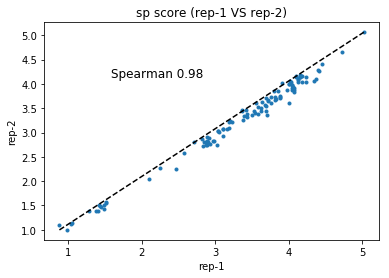


sp
rep-1
rep-3
0.99


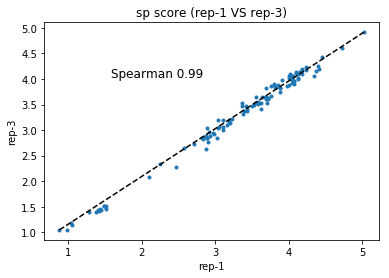


sp
rep-2
rep-3
0.99


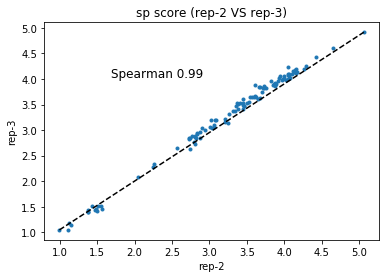


spd
rep-1
rep-2
0.99


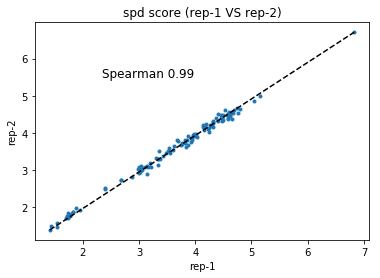


spd
rep-1
rep-3
0.99


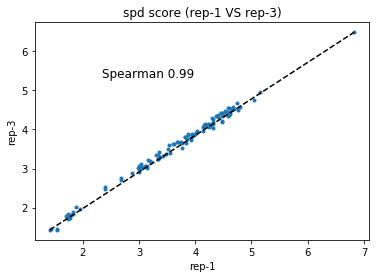


spd
rep-2
rep-3
0.99


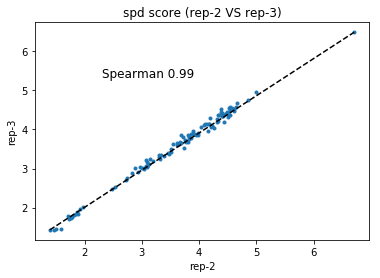


CoH
rep-1
rep-2
0.98


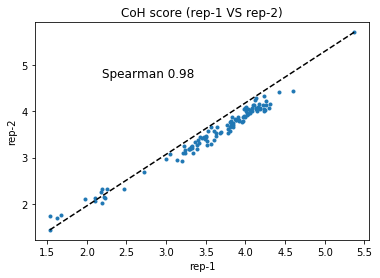


CoH
rep-1
rep-3
0.98


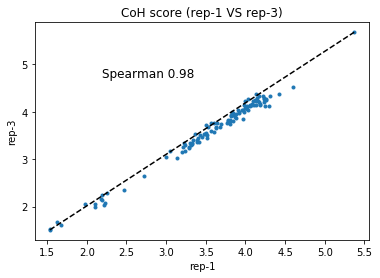


CoH
rep-2
rep-3
0.98


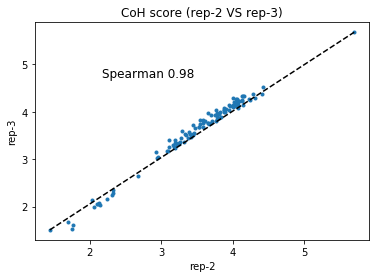


PEG
rep-1
rep-2
0.98


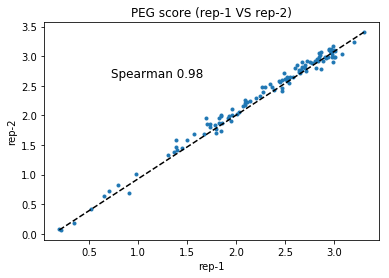


PEG
rep-1
rep-3
0.98


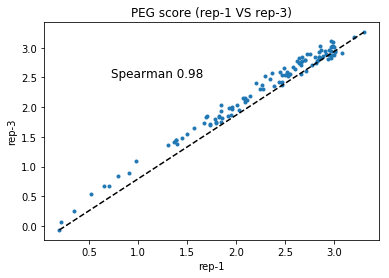


PEG
rep-2
rep-3
0.98


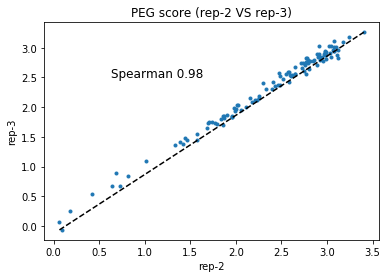


HP1a
rep-1
rep-2
0.95


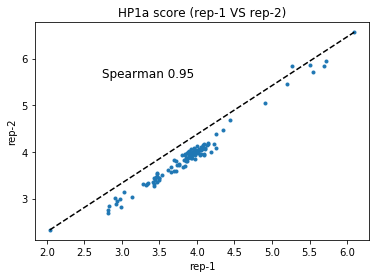


HP1a
rep-1
rep-3
0.93


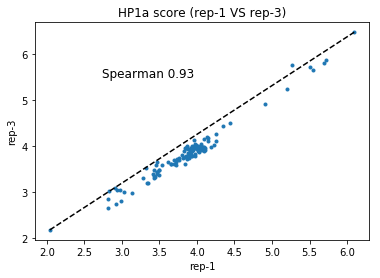


HP1a
rep-2
rep-3
0.92


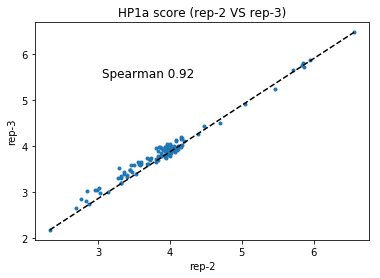

In [18]:
# Check the reproducibility
for agent in agent_list:
    ID_scores = agent_ID_scores[agent]
    for i in range(repnum-1):
        for j in range(i+1, repnum):
            X, Y = [], []
            for ID in target_IDs:
                scores = ID_scores[ID]
                X.append(scores[i])
                Y.append(scores[j])
            corr = scipy.stats.spearmanr(X, Y)[0]

            print "%s" % (agent)
            print "rep-%d" % (i+1)
            print "rep-%d" % (j+1)
            print "%1.2f" % (corr)
            
            fig = plt.figure()
            plt.plot(X, Y, '.')
            plt.plot([min(X), max(X)], [min(Y), max(Y)], 'k--')
            plt.annotate("Spearman %1.2f" % (corr),
                         xy=(0.2, 0.75),
                         fontsize=12,
                         xycoords='axes fraction')
            plt.title("%s score (rep-%s VS rep-%s)" % (agent, i+1, j+1))
            plt.xlabel("rep-%s" % (i+1))
            plt.ylabel("rep-%s" % (j+1))
            plt.show()
            plt.close()
            print

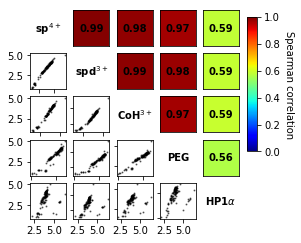

In [19]:
### plot correlation between agent
# re-organize data
agent_data = {}
agent_label = {}
for agent in agent_list:
    data = [np.mean(agent_ID_scores[agent][ID]) for ID in target_IDs]
    agent_data[agent] = data
    agent_label[agent] = agent_symbol[agent]
    
# plot correlation matrix
graphics.plot_corr_matrix(agent_data,
                          agent_label,
                          ids = agent_list,
                          scatter_style='dot',
                          ms=2,
                          alpha=0.5,
                          cmap='jet',
                          vmin=0,
                          vmax=1,
                          fig_scale=0.5,
                          cbar=True,
                          note='PTMlib_agent',
                          save_path='./data/',
                          save_type='svg',
                          save=True)


In [20]:
# compute score difference compared to Wild-type
target_IDs_exceptWT = sorted(list(set(target_IDs) - set(cate_IDs['WT'])))
agent_ID_dscores = {}

for agent in agent_list:
    ID_scores = agent_ID_scores[agent]
    for rep in range(repnum):
        WT_score = []
        for ID in cate_IDs['WT']:
            score = ID_scores[ID][rep]
            WT_score.append(score)
        WT_score = np.mean(WT_score)

        for ID in target_IDs_exceptWT:
            score = ID_scores[ID][rep]
            dscore = score - WT_score

            if agent not in agent_ID_dscores:
                agent_ID_dscores[agent] = {}
            if ID not in agent_ID_dscores[agent]:
                agent_ID_dscores[agent][ID] = []
            agent_ID_dscores[agent][ID].append(dscore)


In [21]:
# compute average and error
agent_ID_mdscore = {}
agent_ID_edscore = {}
for agent in agent_list:
    ID_dscores = agent_ID_dscores[agent]
    for ID in ID_dscores:
        dscores = ID_dscores[ID]
        mdscore = np.mean(dscores)
        edscore = np.std(dscores)

        if agent not in agent_ID_mdscore:
            agent_ID_mdscore[agent] = {}
        agent_ID_mdscore[agent][ID] = mdscore

        if agent not in agent_ID_edscore:
            agent_ID_edscore[agent] = {}
        agent_ID_edscore[agent][ID] = edscore

In [22]:
# compute statistical significance compared to WT control
agent_ID_pvalue = {}
for agent in agent_list:
    ID_scores = agent_ID_scores[agent]
    WT_scores = []
    for ID in cate_IDs['WT']:
        WT_scores += ID_scores[ID]
        
    for ID in target_IDs_exceptWT:
        scores = ID_scores[ID]
        pvalue = stats.ttest_ind(scores,
                                 WT_scores,
                                 equal_var=False)[1]
        if agent not in agent_ID_pvalue:
            agent_ID_pvalue[agent] = {}
        agent_ID_pvalue[agent][ID] = pvalue

In [23]:
# PCA analysis on the state vectors combining all data
ID_state = {}
for ID in target_IDs:
    state = []
    for agent in agent_list:
        scores = agent_ID_scores[agent][ID]
        state.append(np.mean(scores))
    ID_state[ID] = state

X = [ID_state[ID] for ID in target_IDs]
scaler = preprocessing.StandardScaler().fit(X)
X_scaled = scaler.transform(X)
pca = PCA().fit(X_scaled)
Xr = pca.transform(X_scaled)

ID_PCA = {target_IDs[i]:(Xr[i][0], Xr[i][1]) for i in range(len(target_IDs))}

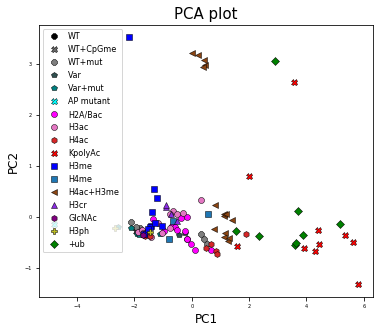

In [24]:
# Plot PCA
group_color = {"H2A/Bac":"magenta",
               "H3ac":"tab:pink",
               "H4ac":"tab:red",
               "KpolyAc":"red",
               "H4ac+H3me":"saddlebrown",
               "H3me":"blue",
               "H4me":"tab:blue",
               "H3cr":"blueviolet",
               "GlcNAc":"purple",
               'WT':"black",
               "WT+CpGme":"dimgray",
               'WT+mut':"tab:gray",
               "+ub":"green",
               'Var':"darkslategray",
               'Var+mut':"teal",
               "H3ph":"tab:olive",
               "AP mutant":"cyan"}

group_marker = {"H2A/Bac":"o",
                "H3ac":"o",
                "H4ac":"h",
                "KpolyAc":"X",
                "H4ac+H3me":"<",
                "H3me":"s",
                "H4me":"s",
                "H3cr":"^",
                "GlcNAc":"h",
                'WT':"8",
                "WT+CpGme":"X",
                'WT+mut':"8",
                "+ub":"D",
                'Var':"p",
                'Var+mut':"p",
                "H3ph":"P",
                "AP mutant":"X"}

group_list = ['WT', "WT+CpGme", 'WT+mut', 'Var', 'Var+mut', "AP mutant", "H2A/Bac", "H3ac", "H4ac", "KpolyAc", "H3me", "H4me", "H4ac+H3me", "H3cr","GlcNAc","H3ph", "+ub"]

fig = plt.figure(figsize=(6,5))
for group in group_list:
    IDs = group_IDs[group]
    color = group_color[group]
    marker = group_marker[group]
    alpha = 1.0
    mew = 0.5 
    for i in range(len(IDs)):
        if i == 0:
            label = group
        else:
            label = None
        ID = IDs[i]
        x, y = ID_PCA[ID]
        plt.plot(x, y,
                 '.',
                 color=color,
                 marker=marker,
                 mew=mew,
                 mec='k',
                 alpha=alpha,
                 label=label)

plt.title("PCA plot", fontsize=15)
plt.xlabel('PC1', fontsize=12)
plt.ylabel('PC2', fontsize=12)
plt.gca().tick_params(axis='both', which='major', labelsize=5)
plt.gca().tick_params(axis='both', which='minor', labelsize=5)
plt.legend(fontsize=8)
plt.savefig("./data/" + "PCA_PTM.svg", format='svg', bbox_inches='tight')
plt.show()
plt.close()



sp


/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


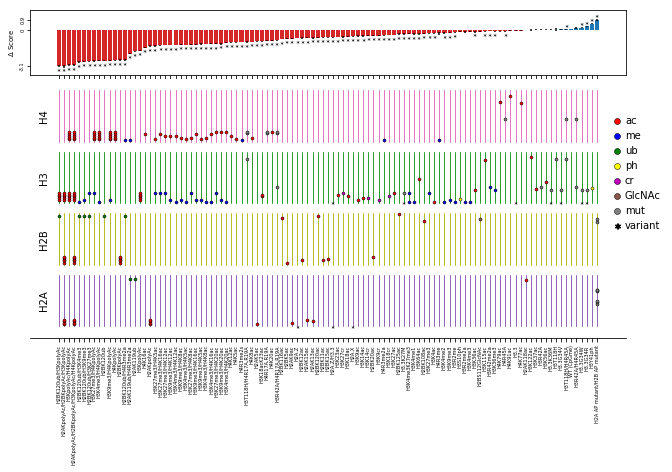


spd


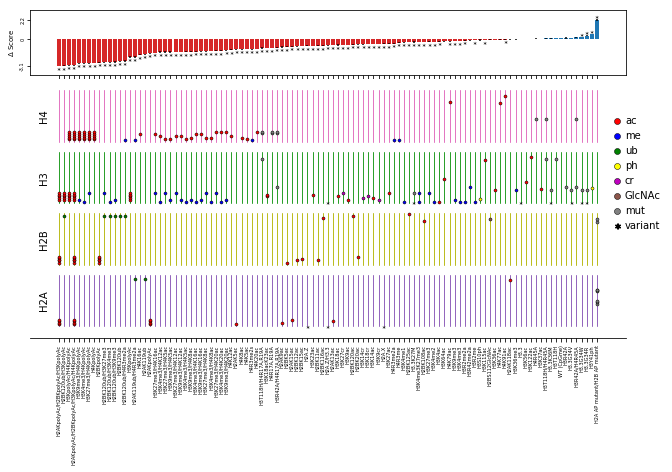


CoH


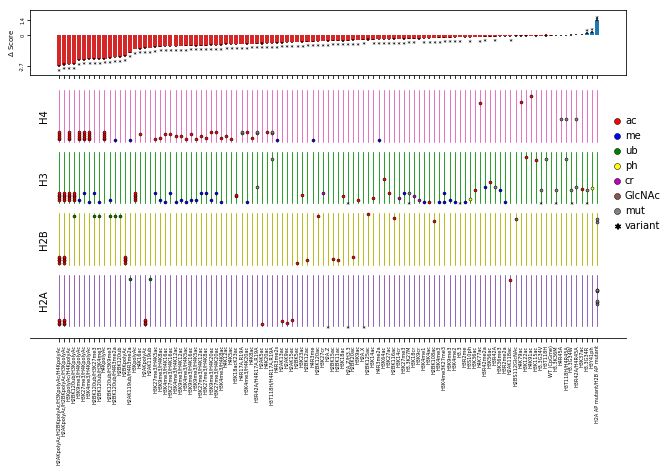


PEG


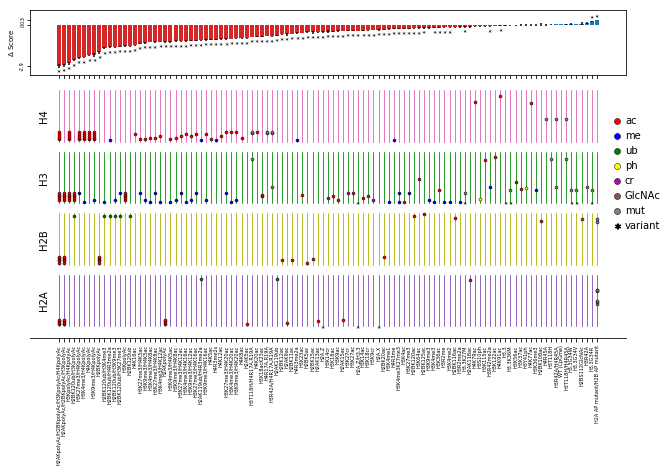


HP1a


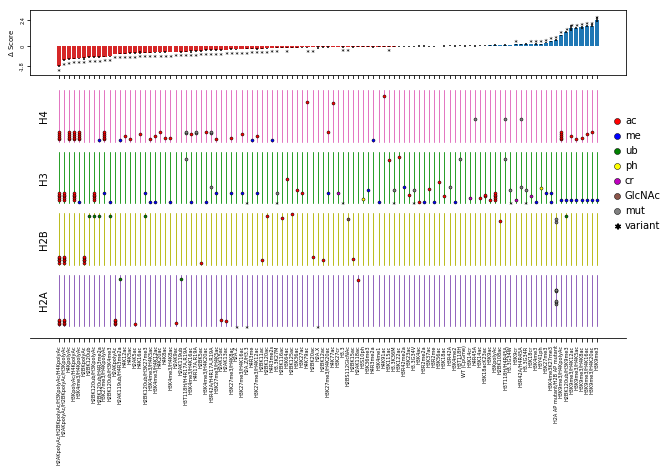

In [25]:
# plot ladder-bar plot
for agent in agent_list:
    ID_mdscore = agent_ID_mdscore[agent]
    ID_edscore = agent_ID_edscore[agent]
    ID_pvalue = agent_ID_pvalue[agent]

    print '%s' % (agent)
    ladder_bar_plot (ID_mdscore,
                     ID_edscore,
                     ID_minfo,
                     ID_shortname,
                     ID_pvalue=ID_pvalue,
                     sig_cutoff=0.05,
                     IDs=target_IDs_exceptWT,
                     figsize=(9,7),
                     height_ratios=[0.5, 2],
                     ylabel="$\Delta$ Score",
                     save_path='./data/',
                     save=True,
                     note=agent)
    print
    

In [26]:
# plot symbol scaled and colored by score
for agent in agent_list:
    ID_mdscore = agent_ID_mdscore[agent]
    plot_scaled_symbols (ID_mdscore,
                         ID_minfo,
                         ID_shortname,
                         IDs=cate_IDs['WT+1PTM'])